In [1]:
%cd ..

/sunjinsheng/codebase/var_mar


In [2]:
# MAR imports:
import torch
import numpy as np
from models import mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image, make_grid
from torchvision.utils import save_image, make_grid
from util import download
from PIL import Image
from IPython.display import display
from safetensors.torch import load_file
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

# 1. Load and download pre-trained MAR models

In [3]:
model_type = "mar_huge" #@param ["mar_base", "mar_large", "mar_huge"]
num_sampling_steps_diffloss = 100 #@param {type:"slider", min:1, max:1000, step:1}
if model_type == "mar_base":
  # download.download_pretrained_marb(overwrite=False)
  diffloss_d = 6
  diffloss_w = 1024
elif model_type == "mar_large":
  # download.download_pretrained_marl(overwrite=False)
  diffloss_d = 8
  diffloss_w = 1280
elif model_type == "mar_huge":
  # download.download_pretrained_marh(overwrite=False)
  diffloss_d = 12
  diffloss_w = 1536
else:
  raise NotImplementedError
print('load model...')
model = mar.__dict__[model_type](
  buffer_size=64,
  diffloss_d=diffloss_d,
  diffloss_w=diffloss_w,
  num_sampling_steps=str(num_sampling_steps_diffloss)
).to(device)
vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path=None).to(device)
ckpt = load_file('checkpoints/mar-huge.safetensors', device='cuda')
model.load_state_dict(ckpt)
model.eval() # important!
ckpt = load_file('checkpoints/kl16.safetensors', device='cuda')
vae.load_state_dict(ckpt)
vae.eval()
print('ckpt loaded')

load model...
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
ckpt loaded


## Sample from Pre-trained MAR Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

In [4]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 64 #@param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.0 #@param {type:"slider", min:0.9, max:1.1, step:0.01}
class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

### sample 

In [ ]:
def show_image(token):
    samples = make_grid(token, nrow=int(samples_per_row), normalize=True, padding=3)
    samples = samples.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    return Image.fromarray(samples)

### single sample

In [ ]:
with torch.amp.autocast('cuda'):
  sampled_tokens = model.sample_tokens(
      bsz=len(class_labels), num_iter=num_ar_steps,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      labels=torch.Tensor(class_labels).long().cuda(),
      temperature=temperature, progress=True)
  sampled_images = vae.decode(sampled_tokens / 0.2325)

### multiple sample

In [7]:
with torch.amp.autocast('cuda'):
  list_tokens, list_masks = model.sample_tokens_multi_outputs(
      bsz=len(class_labels), num_iter=num_ar_steps,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      labels=torch.Tensor(class_labels).long().cuda(),
      temperature=temperature, progress=True)

  # sampled_images = vae.decode(sampled_tokens / 0.2325)

100%|██████████| 64/64 [00:58<00:00,  1.09it/s]


In [35]:
mask_ = list_masks[0]
mask_.shape

torch.Size([8, 256])

In [26]:
token_ = list_tokens[0]
token_ = model.unpatchify(token_)
token = vae.decode(token_ / 0.2325)
token_.shape, token.shape

(torch.Size([8, 16, 16, 16]), torch.Size([8, 3, 256, 256]))

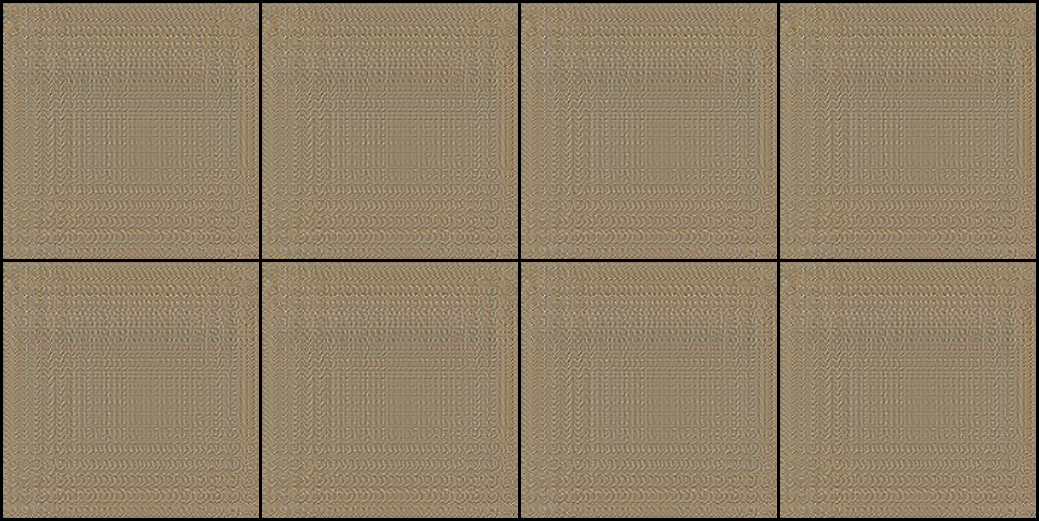

In [24]:
show_image(token)

In [ ]:
# Save and display images:
# save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
grid = make_grid(sampled_images, nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# Add 0.5 after unnormalizing to [0, 255] to round to the nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
samples = Image.fromarray(ndarr)
display(samples)

## Sample test

In [5]:
class_labels = 207, 
bsz=len(class_labels)

num_iter=num_ar_steps
cfg=cfg_scale
cfg_schedule=cfg_schedule
labels=torch.Tensor(class_labels).long().cuda()
temperature=temperature
progress=True
bsz, cfg

(1, 4)

In [6]:
def mask_by_order(mask_len, order, bsz, seq_len):
    masking = torch.zeros(bsz, seq_len).cuda()
    masking = torch.scatter(masking, dim=-1, index=order[:, :mask_len.long()], src=torch.ones(bsz, seq_len).cuda())
    return masking

In [8]:
indices = list(range(num_iter))
# if progress:
#     indices = tqdm(indices)
indices

[0, 1, 2, 3, 4]

In [9]:
model.seq_len, model.buffer_size

(256, 64)

In [10]:
# def sample_tokens(model, bsz, num_iter=64, cfg=1.0, cfg_schedule="linear", labels=None, temperature=1.0, progress=False):
with torch.no_grad():
    # init and sample generation orders
    mask = torch.ones(bsz, model.seq_len).cuda()
    tokens = torch.zeros(bsz, model.seq_len, model.token_embed_dim).cuda()
    orders = model.sample_orders(bsz)

In [ ]:
num_iter = 5
list_masks = []
list_tokens = []
list_mask_ratios = []
list_mask_lens = []
list_mask_to_preds = []
list_xs = []
list_zs = []

In [11]:
mask.shape, tokens.shape, orders.shape

(torch.Size([1, 256]), torch.Size([1, 256, 16]), torch.Size([1, 256]))

In [ ]:
with torch.no_grad():
    # class embedding and CFG
    if labels is not None:
        class_embedding = model.class_emb(labels)
    else:
        class_embedding = model.fake_latent.repeat(bsz, 1)
    if not cfg == 1.0:
        class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(bsz, 1)], dim=0)

In [ ]:
with torch.no_grad():
    # generate latents
    for step in indices:
        print(step)
        cur_tokens = tokens.clone()

        list_masks.append(mask.clone())

        if not cfg == 1.0:
            tokens = torch.cat([tokens, tokens], dim=0)
            # class_embedding = torch.cat([class_embedding, model.fake_latent.repeat(bsz, 1)], dim=0)
            mask = torch.cat([mask, mask], dim=0)

        # mae encoder
        print('mae encoder')
        x = model.forward_mae_encoder(tokens, mask, class_embedding)
        list_xs.append(x.clone())
        # mae decoder
        print('mae decoder')
        z = model.forward_mae_decoder(x, mask)
        list_zs.append(z.clone())

        # mask ratio for the next round, following MaskGIT and MAGE.
        mask_ratio = np.cos(np.pi / 2. * (step + 1) / num_iter)
        # print(mask_ratio)
        list_mask_ratios.append(mask_ratio)
        mask_len = torch.Tensor([np.floor(model.seq_len * mask_ratio)]).cuda()
        # masks out at least one for the next iteration
        mask_len = torch.maximum(torch.Tensor([1]).cuda(),
                                    torch.minimum(torch.sum(mask, dim=-1, keepdims=True) - 1, mask_len))
        list_mask_lens.append(mask_len)

        # get masking for next iteration and locations to be predicted in this iteration
        mask_next = mask_by_order(mask_len[0], orders, bsz, model.seq_len)
        if step >= num_iter - 1:
            mask_to_pred = mask[:bsz].bool()
        else:
            mask_to_pred = torch.logical_xor(mask[:bsz].bool(), mask_next.bool())
        mask = mask_next
        if not cfg == 1.0:
            mask_to_pred = torch.cat([mask_to_pred, mask_to_pred], dim=0)

        # sample token latents for this step
        z = z[mask_to_pred.nonzero(as_tuple=True)]
        # cfg schedule follow Muse
        if cfg_schedule == "linear":
            cfg_iter = 1 + (cfg - 1) * (model.seq_len - mask_len[0]) / model.seq_len
        elif cfg_schedule == "constant":
            cfg_iter = cfg
        else:
            raise NotImplementedError
        sampled_token_latent = model.diffloss.sample(z, temperature, cfg_iter)
        if not cfg == 1.0:
            sampled_token_latent, _ = sampled_token_latent.chunk(2, dim=0)  # Remove null class samples
            mask_to_pred, _ = mask_to_pred.chunk(2, dim=0)
        list_mask_to_preds.append(mask_to_pred)
        cur_tokens[mask_to_pred.nonzero(as_tuple=True)] = sampled_token_latent
        tokens = cur_tokens.clone()
        list_tokens.append(tokens)

0
mae encoder
torch.Size([2, 256, 16]) torch.Size([2, 256]) torch.Size([2, 1280])
after z_proj x.shape: torch.Size([2, 256, 1280])
after concat buffer x.shape: torch.Size([2, 320, 1280])
after concat buffer mask_with_buffer.shape: torch.Size([2, 320])
class_embedding shape: torch.Size([2, 1, 1280])
before add pos embed x.shape: torch.Size([2, 320, 1280])
after add pos embed x.shape: torch.Size([2, 320, 1280])
after ln x.shape: torch.Size([2, 320, 1280])
after drop x.shape: torch.Size([2, 64, 1280])
after block x.shape: torch.Size([2, 64, 1280])
after norm x.shape: torch.Size([2, 64, 1280])
mae encoder
input x.shape: torch.Size([2, 64, 1280])
embeded x.shape: torch.Size([2, 64, 1280])
x_after_pad.shape: torch.Size([2, 320, 1280])
add pos embed x.shape: torch.Size([2, 320, 1280])
block x.shape: torch.Size([2, 320, 1280])
decoder norm x.shape: torch.Size([2, 320, 1280])
remove cls embed x.shape: torch.Size([2, 256, 1280])
add diffusion pos embed x.shape: torch.Size([2, 256, 1280])
1
mae e

In [ ]:
m = list_masks[2]
m[m.nonzero(as_tuple=True)]

In [ ]:
model.encoder_pos_embed_learned.shape

In [ ]:
a = torch.zeros(3,4,5)
b = torch.ones(3,1,5)
a[:, :2,] = b
a

In [ ]:
from einops import repeat, rearrange

In [ ]:
[f"{a:.4f}" for a in list_mask_ratios]

In [ ]:
[a[0].item() for a in list_mask_lens]

## show mask 

In [ ]:
# mask = list_masks[4]
mask = mask_next
mask = mask.float()
# mask = torch.ones(bsz, model.seq_len).cuda()
mask_show = repeat(mask, "n l -> n l d", d=3)
mask_show = rearrange(mask_show, 'n (h w) d -> n d h w', h = 16)
mask_show = repeat(mask_show, 'n d h w -> n d p h q w', p = 16, q= 16)
sampled_images = rearrange(mask_show, 'n d p h q w -> n (h w) d p q')
# Save and display images:
# save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
grid = make_grid(sampled_images[0], nrow=int(16), normalize=True, value_range=(-1, 1))
# Add 0.5 after unnormalizing to [0, 255] to round to the nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
samples = Image.fromarray(ndarr)
display(samples)

In [ ]:
# mask = tokens
mask = list_tokens[4]

# mask = mask.float()
# mask = torch.ones(bsz, model.seq_len).cuda()
# mask_show = repeat(mask, "n l -> n l d", d=3)
mask_show = mask[:,:,:3]
mask_show = rearrange(mask_show, 'n (h w) d -> n d h w', h = 16)
mask_show = repeat(mask_show, 'n d h w -> n d p h q w', p = 16, q= 16)
sampled_images = rearrange(mask_show, 'n d p h q w -> n (h w) d p q')
# Save and display images:
# save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
grid = make_grid(sampled_images[0], nrow=int(16), normalize=True, value_range=(-1, 1))
# Add 0.5 after unnormalizing to [0, 255] to round to the nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
samples = Image.fromarray(ndarr)
display(samples)

## show images

In [ ]:
with torch.no_grad():
    # unpatchify
    tokens = model.unpatchify(tokens)
    sampled_images = vae.decode(tokens / 0.2325)
# return tokens
# Save and display images:
# save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
grid = make_grid(sampled_images, nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
# Add 0.5 after unnormalizing to [0, 255] to round to the nearest integer
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
samples = Image.fromarray(ndarr)
display(samples)